In [1]:
### WIOT MATRICES DEMONSTRATION

In [2]:
### INITIALIZATION

import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats ### To annotate fliers
import seaborn as sns

In [3]:
### PARAMETERS

### Date Range defining:
str_year_start = '1994'
### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Commodity to Industry shares:
str_path_unc_ind_weights_hdf = 'Data_Files/Result_Files/unc_ind_weights.h5'
str_path_unc_ind_weights_agg_hdf = 'Data_Files/Result_Files/unc_ind_weights_agg.h5'
str_gics_key = 'gics_io'
### Product / Industry mapping path:
str_path_matrix_map = 'Data_Files/Source_Files/WIOT_mapping_detailed.xlsx'
str_sheet_matrix = 'Matrix to Load'
str_sheet_gics = 'GICS 2018'
str_sheet_hs = 'HS'
str_sheet_ebops = 'EBOPS 2010'
str_sheet_nace_r = 'WIOT R to COMTRADE'
str_sheet_nace_c = 'WIOT C to GICS'
### Primiary cells path:
str_path_primary = 'Data_Files/Test_Files/WIOT2014_Total_Total.xlsx'
str_sheet_cells = 'shares'
### Augmented bilateral export:
str_path_export_bilateral = 'Data_Files/Source_Files/comtrade_export_bilateral.h5'
str_key_unc_export = 'export_augmented'
### Old way resulting table:
str_path_total_shares = 'Data_Files/Test_Files/total_shares_v2.csv'
### Goods classification (HS1992):
str_hs_url = 'https://comtrade.un.org/Data/cache/classificationH0.json'

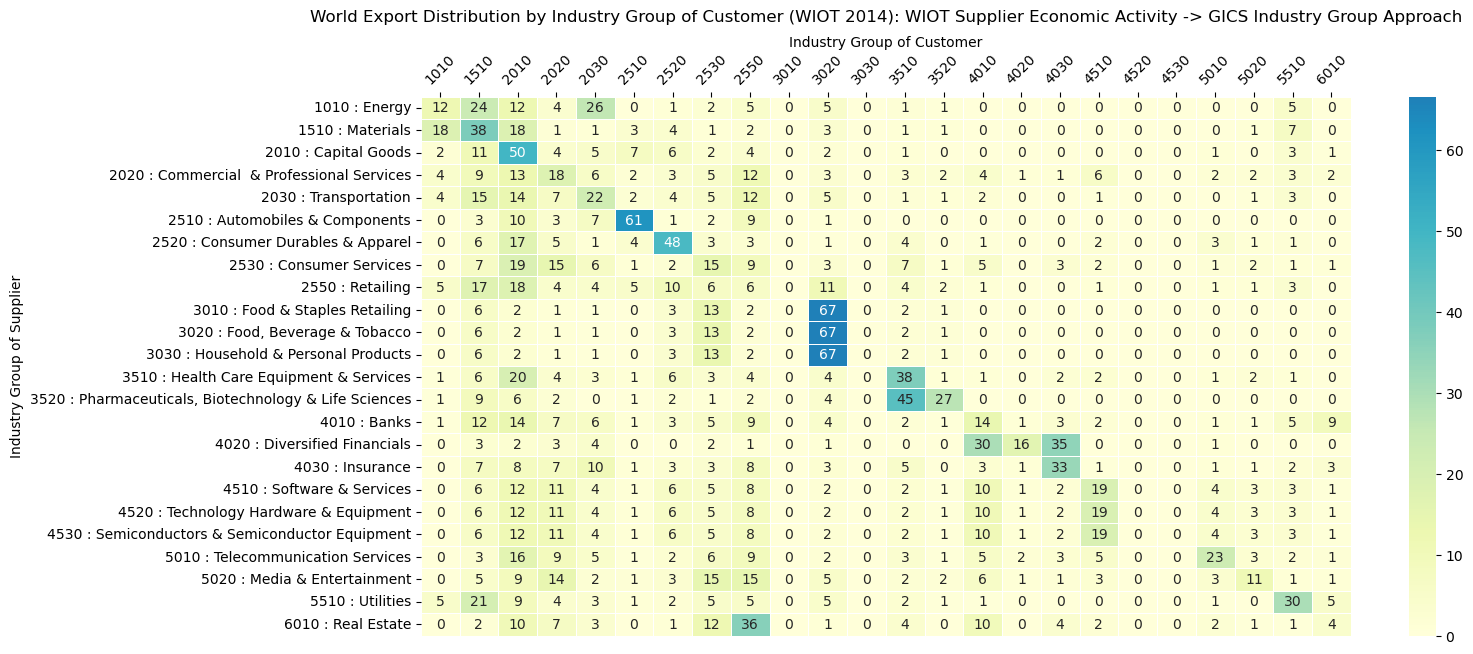

Old Version of Export Distribution Matrix: Supplier & Customer NACE Activities straightly mapped to GICS Industry Groups with GICS Groups shares consolidation by Columns & Rows
Some features:
1. Some rows (3020 -> 3010, 3020 -> 3030, 4510 -> 4520, 4510 -> 4530) are duplicated
2. Groups contain products that surely have different distribution


In [4]:
### OLD VERSION MATRIX

### Loading old version shares:
df_old_version = pd.read_csv(str_path_total_shares, index_col = 0)
df_old_version.index.names = ['Group_Code']
df_old_version.index = df_old_version.index.astype('str')
### Adding Industry Group Names:
df_gics_groups = pd.read_excel(str_path_matrix_map, str_sheet_gics, skiprows = 4, dtype = 'str', usecols = [2, 3]).dropna()
df_gics_groups.columns = ['Group_Code', 'Group_Name']
df_gics_groups['Industry_Group'] = df_gics_groups['Group_Code'].str.cat([' : '] * len(df_gics_groups)).str.cat(df_gics_groups['Group_Name'])
ser_gics_groups = df_gics_groups.set_index('Group_Code')['Industry_Group']
df_old_version = df_old_version.join(ser_gics_groups).set_index('Industry_Group')
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_old_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Industry Group of Supplier')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014): WIOT Supplier Economic Activity -> GICS Industry Group Approach', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('Old Version of Export Distribution Matrix: Supplier & Customer NACE Activities straightly mapped to GICS Industry Groups with GICS Groups shares ' + 
      'consolidation by Columns & Rows')
print('Some features:')
print('1. Some rows (3020 -> 3010, 3020 -> 3030, 4510 -> 4520, 4510 -> 4530) are duplicated')
print('2. Groups contain products that surely have different distribution')

In [22]:
### DETAILED DISTRIBUTION (WORLD TO WORLD)

gc.collect()
### Loading World to World Detailed Distribution:
dt_control = pd.to_datetime('2020-12-31')
ser_ww_ww_detailed = pd.read_hdf(str_path_unc_ind_weights_agg_hdf, where = "Date in [dt_control]").droplevel('Date')['WW', 'WW']
### Aggregating to Industry Groups of Customer:
df_ww_ww_group = ser_ww_ww_detailed.to_frame().reset_index('GICS_Industry_Code')
df_ww_ww_group['GICS_Group_Code'] = df_ww_ww_group['GICS_Industry_Code'].str[: 4]
ser_ww_ww_group = df_ww_ww_group.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                .groupby(['Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
### Adding Commodity Descriptions:
ser_hs_info = pd.read_excel(str_path_matrix_map, str_sheet_hs, dtype = 'str').dropna().set_index('Commodity_ID')['AG2']
ser_hs_info = ser_hs_info.str.partition(';')[0]
ser_hs_info.name = 'Commodity_Description'
ser_ebops_info = pd.read_excel(str_path_matrix_map, str_sheet_ebops, dtype = 'str').dropna().set_index('Commodity_ID')['Service Description']
ser_ebops_info.name = 'Commodity_Description'
ser_comm_info = pd.concat([ser_hs_info, ser_ebops_info], axis = 0)
ser_ww_ww_group = ser_ww_ww_group.to_frame().join(ser_comm_info).set_index('Commodity_Description', append = True).squeeze()#.droplevel('Commodity_ID')\
#                                 .reorder_levels([2, 0, 1]).sort_index()

In [17]:
### NACE R to UN Comtrade Map:

### R Map:
df_r_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_r, dtype = str)[['WIOT Exporter Code', 'WIOT Description', 'HS Goods Code', 'EBOPS Service Code']]
df_r_map[['WIOT Exporter Code', 'WIOT Description']] = df_r_map[['WIOT Exporter Code', 'WIOT Description']].ffill()
df_r_map['Commodity_ID'] = df_r_map['HS Goods Code'].combine_first(df_r_map['EBOPS Service Code'])
df_r_map = df_r_map.dropna(subset = ['Commodity_ID']).set_index('Commodity_ID')[['WIOT Exporter Code', 'WIOT Description']]

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [26]:
### TEMP

ser_ww_ww_group#.to_frame().join(df_r_map)

Commodity_ID  Commodity_Group_Code  GICS_Group_Code  Commodity_Description
01            3020                  1010             01 - Animals             0.001271
                                    1510             01 - Animals             0.033076
                                    2010             01 - Animals             0.015792
                                    2020             01 - Animals             0.017054
                                    2030             01 - Animals             0.004531
                                                                                ...   
97            2520                  4530             97 - Works of art        0.005989
                                    5010             97 - Works of art        0.008898
                                    5020             97 - Works of art        0.018639
                                    5510             97 - Works of art        0.014618
                                    6010             97

In [ ]:
### TEMP



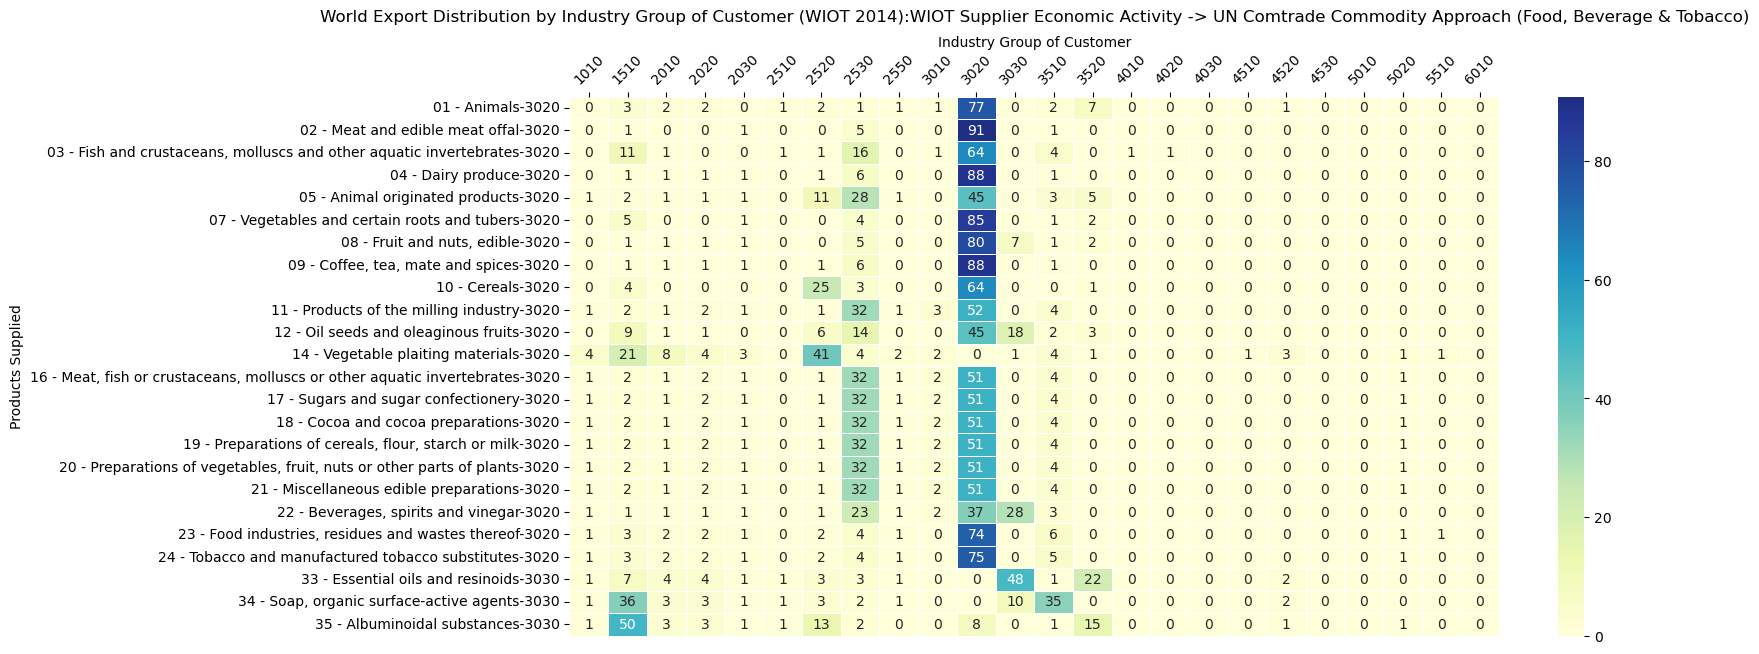

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) Customer NACE Activities mapped to GICS Sub-Industries (1 to n)


In [6]:
### NEW VERSION MATRIX: FOOD, BEVERAGE, TOBACCO

df_new_version = ser_ww_ww_group.loc[:, ['3010', '3020', '3030']].unstack('GICS_Group_Code').fillna(0.0)

### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Food, Beverage & Tobacco)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) ' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')

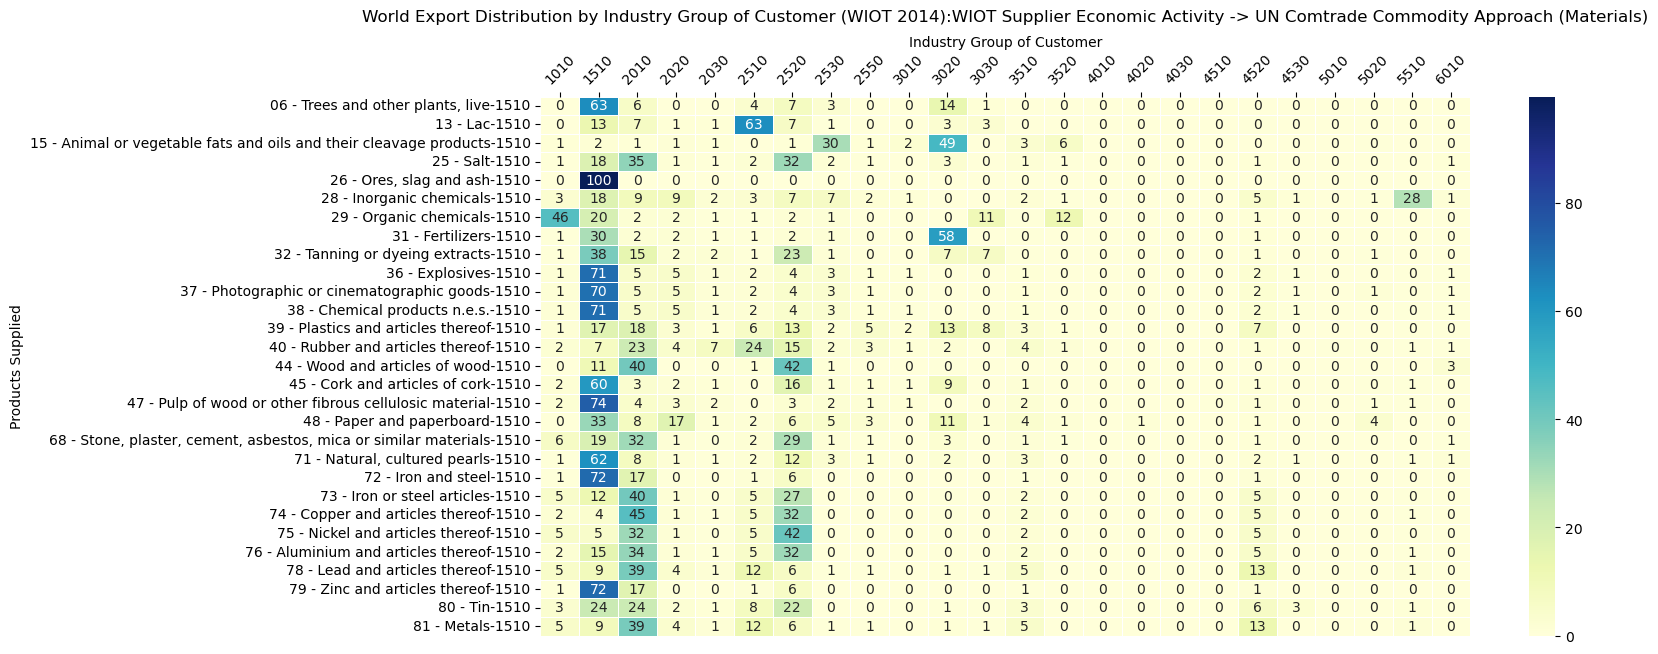

In [7]:
### NEW VERSION MATRIX: MATERIALS

df_new_version = ser_ww_ww_group.loc[:, ['1510']].unstack('GICS_Group_Code').fillna(0.0)

### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Materials)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

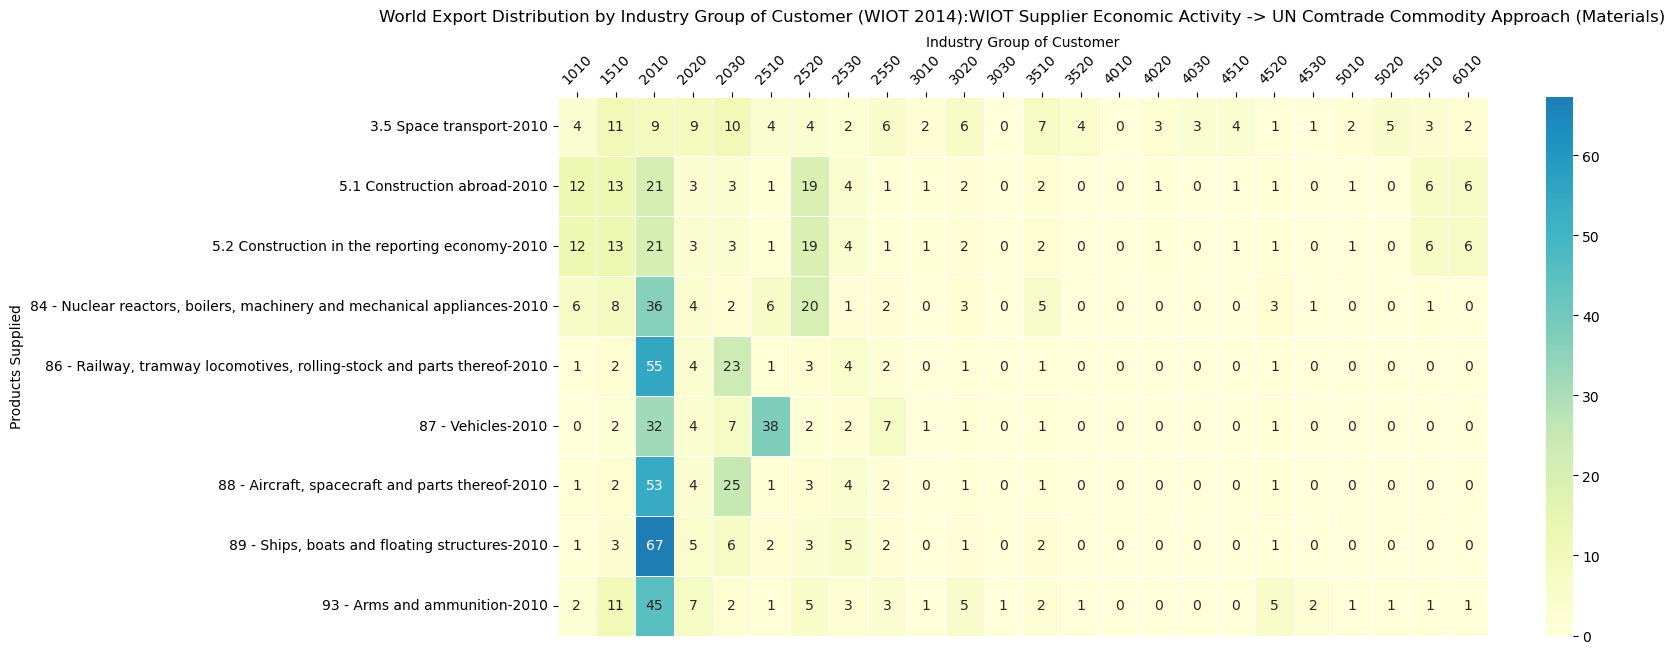

In [8]:
### NEW VERSION MATRIX: CAPITAL GOODS

df_new_version = ser_ww_ww_group.loc[:, ['2010']].unstack('GICS_Group_Code').fillna(0.0)

### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Materials)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

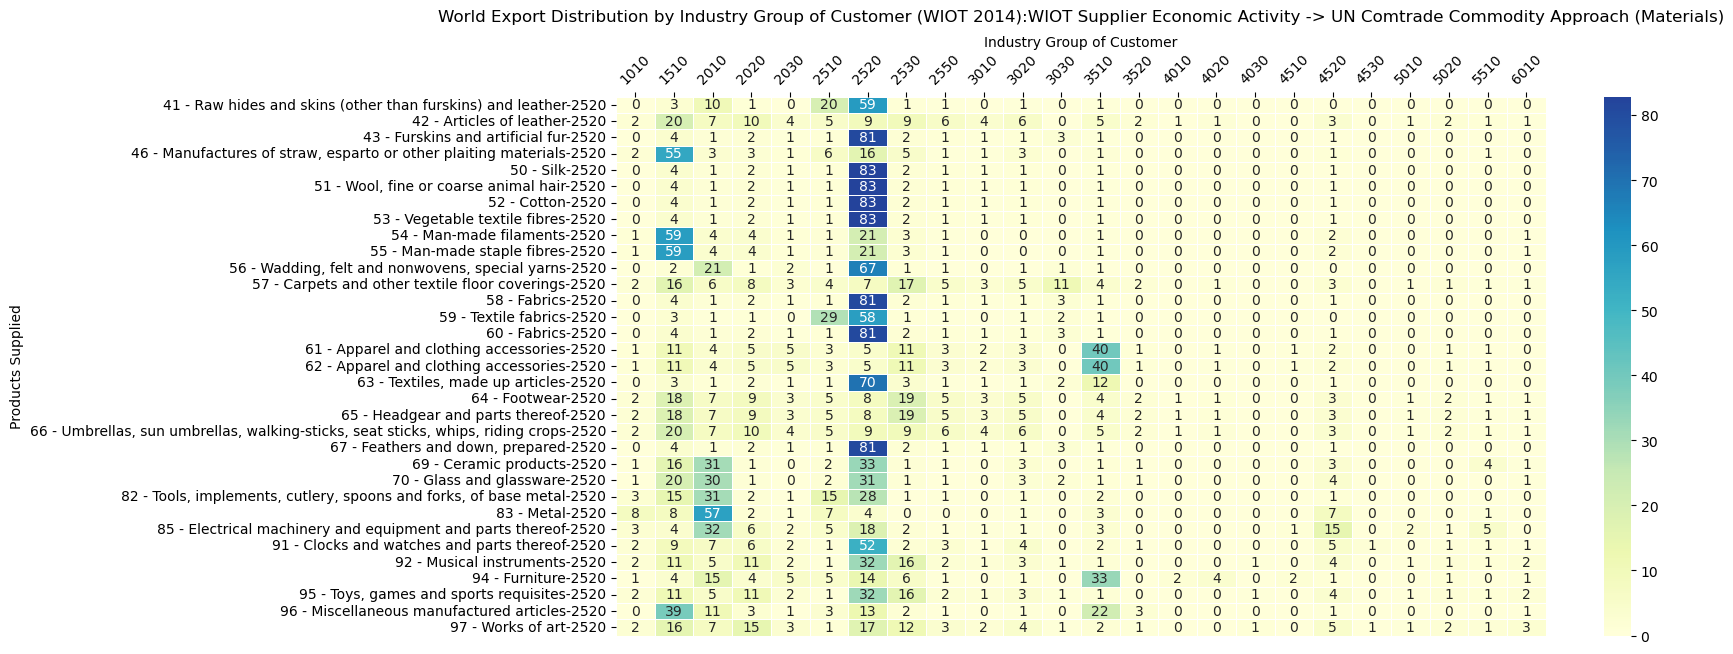

In [9]:
### NEW VERSION MATRIX: CONSUMER DURABLES & APPAREL

df_new_version = ser_ww_ww_group.loc[:, ['2520']].unstack('GICS_Group_Code').fillna(0.0)

### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Materials)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

In [10]:
### DETAILED DISTRIBUTION (BILATERAL DATASET FILTRATION)

gc.collect()
### Loading World to World Detailed Distribution:
str_exporter = 'US'
dt_control = pd.to_datetime('2020-12-31')
ser_from_xx_detailed = pd.read_hdf(str_path_unc_ind_weights_hdf, where = "Date in [dt_control]").droplevel('Date').loc[str_exporter]
### Aggregating to Industry Groups of Customer:
df_from_xx_group = ser_from_xx_detailed.to_frame().reset_index('GICS_Industry_Code')
df_from_xx_group['GICS_Group_Code'] = df_from_xx_group['GICS_Industry_Code'].str[: 4]
ser_from_xx_group = df_from_xx_group.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                .groupby(['Importer', 'Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
### Adding Commodity Descriptions:
ser_hs_info = pd.read_excel(str_path_matrix_map, str_sheet_hs, dtype = 'str').dropna().set_index('Commodity_ID')['AG2']
ser_hs_info = ser_hs_info.str.partition(';')[0]
ser_hs_info.name = 'Commodity_Description'
ser_ebops_info = pd.read_excel(str_path_matrix_map, str_sheet_ebops, dtype = 'str').dropna().set_index('Commodity_ID')['Service Description']
ser_ebops_info.name = 'Commodity_Description'
ser_comm_info = pd.concat([ser_hs_info, ser_ebops_info], axis = 0)
ser_from_xx_group = ser_from_xx_group.to_frame().join(ser_comm_info).set_index('Commodity_Description', append = True).squeeze().droplevel('Commodity_ID')\
                                 .reorder_levels([0, 3, 1, 2]).sort_index()

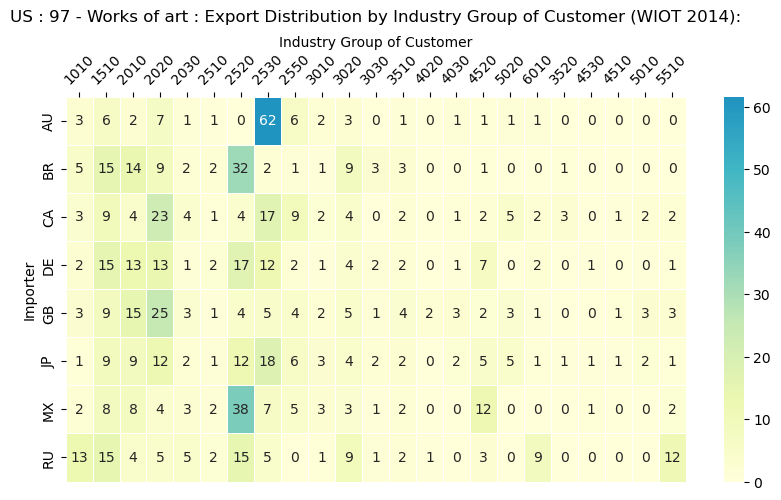

In [11]:
### DETAILED DISTRIBUTION (COUNTRY EXPORT DISTRIBUTION): 97

list_importers = ['AU', 'BR', 'CA', 'DE', 'GB', 'JP', 'MX', 'RU', 'US']
str_comm_description = '97 - Works of art'

df_country_export = ser_from_xx_group.loc[list_importers, str_comm_description].droplevel(['Commodity_Description', 'Commodity_Group_Code'])\
                                     .unstack('GICS_Group_Code').fillna(0.0)
### Heatmap plotting:
plt.figure(figsize = (10, 5))
ax_heatmap = sns.heatmap(df_country_export * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title(str_exporter + ' : ' + str_comm_description + ' : Export Distribution by Industry Group of Customer (WIOT 2014):', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

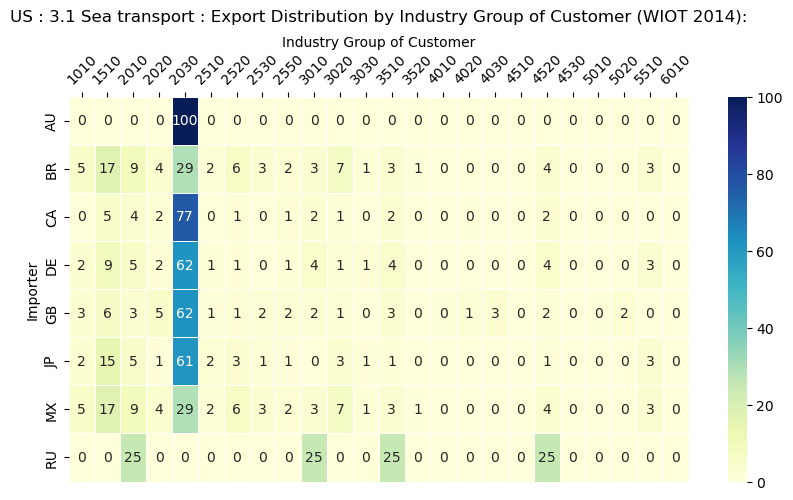

In [12]:
### DETAILED DISTRIBUTION (COUNTRY EXPORT DISTRIBUTION): 3.1

list_importers = ['AU', 'BR', 'CA', 'DE', 'GB', 'JP', 'MX', 'RU', 'US']
str_comm_description = '3.1 Sea transport'

df_country_export = ser_from_xx_group.loc[list_importers, str_comm_description].droplevel(['Commodity_Description', 'Commodity_Group_Code'])\
                                     .unstack('GICS_Group_Code').fillna(0.0)
### Heatmap plotting:
plt.figure(figsize = (10, 5))
ax_heatmap = sns.heatmap(df_country_export * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title(str_exporter + ' : ' + str_comm_description + ' : Export Distribution by Industry Group of Customer (WIOT 2014):', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

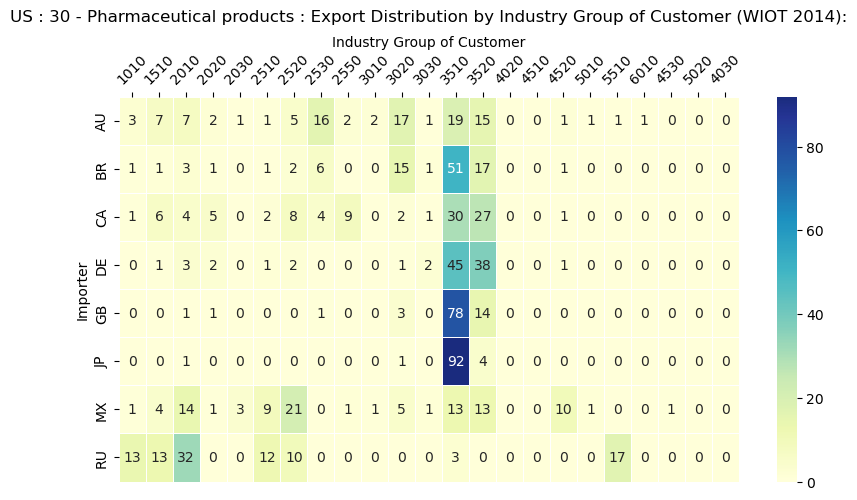

In [13]:
### DETAILED DISTRIBUTION (COUNTRY EXPORT DISTRIBUTION): 30

list_importers = ['AU', 'BR', 'CA', 'DE', 'GB', 'JP', 'MX', 'RU', 'US']
str_comm_description = '30 - Pharmaceutical products'

df_country_export = ser_from_xx_group.loc[list_importers, str_comm_description].droplevel(['Commodity_Description', 'Commodity_Group_Code'])\
                                     .unstack('GICS_Group_Code').fillna(0.0)
### Heatmap plotting:
plt.figure(figsize = (10, 5))
ax_heatmap = sns.heatmap(df_country_export * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title(str_exporter + ' : ' + str_comm_description + ' : Export Distribution by Industry Group of Customer (WIOT 2014):', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

In [42]:
### PRIMARY CELLS PREPARATION

### Basic total shares loading:
ser_total_shares = pd.read_excel(str_path_primary, str_sheet_cells, header = 0).drop('Group', axis = 1).drop([0, 55, 56], axis = 0).set_index('WIOT').stack()
ser_total_shares.index.names = ['WIOT Exporter Code', 'WIOT Importer Code']
### Extracting primary cells:
ser_primary_shares = ser_total_shares[ser_total_shares > 0.05]
ser_primary_shares.name = 'Share'
### R Map:
df_r_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_r, dtype = str)[['WIOT Exporter Code', 'HS Goods Code', 'EBOPS Service Code', 'Commodity Description']]
df_r_map['WIOT Exporter Code'] = df_r_map['WIOT Exporter Code'].ffill()
df_r_map['Commodity_ID'] = df_r_map['HS Goods Code'].combine_first(df_r_map['EBOPS Service Code'])
df_r_map = df_r_map.set_index('WIOT Exporter Code')[['Commodity_ID', 'Commodity Description']].dropna()
### C Map:
df_c_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_c, dtype = str)[['WIOT Importer Code', 'GICS Sub-Industry Code', 'GICS Sub-Industry Name']].dropna()
df_c_map['WIOT Importer Code'] = df_c_map['WIOT Importer Code'].ffill()
df_c_map = df_c_map.dropna(subset = ['GICS Sub-Industry Code']).set_index('WIOT Importer Code')
df_c_map['GICS Sub-Industry Code'] = df_c_map['GICS Sub-Industry Code'].astype(str)
### CMappers consolidation:
df_primary_shares = ser_primary_shares.reset_index('WIOT Importer Code').merge(df_r_map, left_on = 'WIOT Exporter Code', right_on = 'WIOT Exporter Code')\
                                      .set_index('WIOT Importer Code', append = True)
df_primary_shares = df_primary_shares.reset_index('WIOT Exporter Code').merge(df_c_map, left_on = 'WIOT Importer Code', right_on = 'WIOT Importer Code')\
                                      .set_index('WIOT Exporter Code', append = True)
df_primary_shares = df_primary_shares.swaplevel().sort_index()

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [43]:
### UN COMTRADE TO GICS WIOT BASED MATRIX LOADING

### Source table loading:
df_unc_to_gics = pd.read_excel(engine = 'openpyxl', io = str_path_matrix_map, sheet_name = str_sheet_matrix, dtype = str, header = list(range(6)), 
                               index_col = list(range(4)))
df_unc_to_gics.index.names = ['WIOT Exporter Code', 'WIOT_Description', 'Commodity_ID', 'Commodity_Description']
df_unc_to_gics.columns.names = ['WIOT Importer Code', 'WIOT_Description', 'GICS_Sub_Code', 'GICS_Industry_Code', 'GICS_Group_Code', 'GICS_Sub_Name']
### Index levels checker:
df_unc_to_gics.index = df_unc_to_gics.index.set_levels(df_unc_to_gics.index.levels[2].astype('str'), level = 'Commodity_ID')
#### Matrix filtering:
df_unc_to_gics = df_unc_to_gics.drop(index = '---', level = 'Commodity_ID').drop(columns = '---', level = 'GICS_Group_Code')
df_unc_to_gics = df_unc_to_gics.droplevel(['WIOT_Description', 'GICS_Industry_Code', 'GICS_Group_Code', 'GICS_Sub_Name'], axis = 1)
df_unc_to_gics = df_unc_to_gics.droplevel(['WIOT_Description', 'Commodity_Description'])
#df_unc_to_gics['GICS_Sub_Code'] = df_unc_to_gics['GICS_Sub_Code'].astype(str)
### Matrix convertation:
df_unc_to_gics = df_unc_to_gics.replace({'x': False, 'y': True, 'z': True})
gc.collect()
ser_unc_to_gics = df_unc_to_gics.stack(df_unc_to_gics.columns.names).astype(bool)
ser_unc_to_gics.index = ser_unc_to_gics.index.set_levels(ser_unc_to_gics.index.levels[3].astype('str'), level = 'GICS_Sub_Code')
ser_unc_to_gics.name = 'Connection_Flag'

In [44]:
### ADDING CONNECTION FLAGS

df_primary_shares.index.names = ['WIOT Exporter Code', 'WIOT Importer Code']
df_primary_shares = df_primary_shares.set_index(['Commodity_ID', 'GICS Sub-Industry Code'], append = True).reorder_levels([0, 2, 1, 3]).sort_index()
df_primary_shares.index.names = ser_unc_to_gics.index.names
df_primary_shares['Connection_Flag'] = ser_unc_to_gics.reindex(df_primary_shares.index)
df_primary_shares = df_primary_shares.set_index(['Commodity Description', 'GICS Sub-Industry Name'], append = True).reorder_levels([0, 1, 4, 2, 3, 5]).sort_index()

In [49]:
### HS19992 STRUCTURE PREPARATION:

### Data loading:
df_hs_full = pd.DataFrame(pd.read_json(str_hs_url, orient = 'index').squeeze()['results']).set_index('id')
### Parents & Offspring:
ser_ag2 = df_hs_full[df_hs_full['parent'] == 'TOTAL'].drop('parent', axis = 1).squeeze()
ser_ag2.name = 'AG2_Description'
df_ag4 = df_hs_full[df_hs_full['parent'].isin(ser_ag2.index)]
df_ag4.columns = ['AG4_Description', 'Parent']
df_ag4 = df_ag4.merge(ser_ag2, left_on = 'Parent', right_on = 'id').set_index('Parent')[['AG2_Description', 'AG4_Description']]
df_ag4.to_excel('Data_Files/Test_Files/hs_1992_ag4.xlsx')